In [1]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import numpy as np

In [2]:
basic_movie_info = pd.read_parquet('basic_features.parquet')

In [3]:
basic_movie_info.columns

Index(['budget', 'id', 'imdb_id', 'popularity', 'revenue', 'title',
       'release_date', 'cast_popularity', 'crew_popularity', 'star_present'],
      dtype='object')

In [4]:
basic_movie_info = pd.get_dummies(basic_movie_info, columns=['star_present'])
basic_movie_info.head()

,budget,id,imdb_id,popularity,revenue,title,release_date,cast_popularity,crew_popularity,star_present_No,star_present_Yes
0,10400000,360814,tt5074352,22.057,311000000,Dangal,2016-12-21,68.289,72.850,False,True
1,6087315,132316,tt2176013,9.961,256884693,Jab Tak Hai Jaan,2012-11-13,76.745,35.234,False,True
2,7700000,61202,tt1562872,22.366,160000000,Zindagi Na Milegi Dobara,2011-07-15,77.934,91.112,False,True
3,13000000,348892,tt3863552,16.974,150000000,Bajrangi Bhaijaan,2015-07-17,72.644,114.852,False,True
4,286284,441889,tt6108090,12.123,137416709,Secret Superstar,2017-10-19,33.289,35.091,False,True


In [3]:
import hopsworks
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("HOPSWORKS_KEY")

project = hopsworks.login(api_key_value=api_key)

fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/602262
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
movies_fg = fs.get_or_create_feature_group(
    name="movies",
    version=2,
    primary_key= basic_movie_info.columns, 
    description="Movies form TMDB")
movies_fg.insert(basic_movie_info)

Uploading Dataframe: 0.00% |          | Rows 0/322 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: movies_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/602262/jobs/named/movies_2_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f7546193f40>, None)

In [7]:
movie_fg = fs.get_feature_group(name="movies", version=2)
query = movie_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="movies",
                                  version=2,
                                  description="Get movies in the dataset",
                                  labels=["revenue"],
                                  query=query)

In [8]:
data = feature_view.train_validation_test_split(validation_size = 0.1, test_size = 0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.41s) 


In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = data

Training a basic model

In [10]:
X_train.columns

Index(['budget', 'id', 'imdb_id', 'popularity', 'title', 'release_date',
       'cast_popularity', 'crew_popularity', 'star_present_no',
       'star_present_yes'],
      dtype='object')

In [11]:
scaling_factor = 1000000
X_train_scaled = X_train[['budget', 'popularity','cast_popularity', 'crew_popularity', 'star_present_no','star_present_yes']]
X_test_scaled = X_test[['budget', 'popularity','cast_popularity', 'crew_popularity', 'star_present_no','star_present_yes']]
X_val_scaled = X_val[['budget', 'popularity','cast_popularity', 'crew_popularity', 'star_present_no','star_present_yes']]

X_train_scaled[['budget']] = X_train[['budget']]/scaling_factor
y_train_scaled = y_train[['revenue']]/scaling_factor
X_val_scaled[['budget']] = X_val[['budget']]/scaling_factor
y_val_scaled = y_val[['revenue']]/scaling_factor
X_test_scaled[['budget']] = X_test[['budget']]/scaling_factor
y_test_scaled = y_test[['revenue']]/scaling_factor


n_min = 1
n_max = 20
r2s = np.zeros((len(range(n_min,n_max)), 3))
mses = np.zeros((len(range(n_min,n_max)), 3))


for n_neighbours in range(n_min,n_max):
  model = KNeighborsRegressor(n_neighbors=n_neighbours)
  reg = model.fit(X_train_scaled, y_train_scaled)

  print("--------------------------------------------------------------------------")
  # Evaluate on training set
  y_pred = reg.predict(X_train_scaled)
  mse = mean_squared_error(y_train_scaled, y_pred)
  mae = mean_absolute_error(y_train_scaled, y_pred)
  r2 = r2_score(y_train_scaled, y_pred)
  print("Training set scores for %d neighbours:\t mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))
  r2s[n_neighbours - n_min, 0] = r2
  mses[n_neighbours - n_min, 0] = mse


  # Evaluate on test set
  y_pred = reg.predict(X_val_scaled)
  y_pred = np.nan_to_num(y_pred)
  mse = mean_squared_error(y_val_scaled, y_pred)
  mae = mean_absolute_error(y_val_scaled, y_pred)
  r2 = r2_score(y_val_scaled, y_pred)
  print("Validation set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))
  r2s[n_neighbours - n_min, 1] = r2
  mses[n_neighbours - n_min, 1] = mse

  # Evaluate on test set
  y_pred = reg.predict(X_test_scaled)
  y_pred = np.nan_to_num(y_pred)
  mse = mean_squared_error(y_test_scaled, y_pred)
  mae = mean_absolute_error(y_test_scaled, y_pred)
  r2 = r2_score(y_test_scaled, y_pred)
  print("Test set scores for %d neighbours:\t mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))
  r2s[n_neighbours - n_min,2] = r2
  mses[n_neighbours - n_min, 2] = mse

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--------------------------------------------------------------------------
Training set scores for 1 neighbours:	 mse 0.000000, mae 0.000000, r2 1.000000
Validation set scores for 1 neighbours: mse 350.938969, mae 12.017841, r2 -0.363157
Test set scores for 1 neighbours:	 mse 3448.237252, mae 26.137397, r2 -2.268880
--------------------------------------------------------------------------
Training set scores for 2 neighbours:	 mse 368.138230, mae 8.420453, r2 0.685691
Validation set scores for 2 neighbours: mse 391.996592, mae 11.889985, r2 -0.522638
Test set scores for 2 neighbours:	 mse 1516.449196, mae 20.344482, r2 -0.437572
--------------------------------------------------------------------------
Training set scores for 3 neighbours:	 mse 529.930730, mae 10.204937, r2 0.547555
Validation set scores for 3 neighbours: mse 182.450472, mae 9.960244, r2 0.291305
Test set scores for 3 neighbours:	 mse 1123.498020, mae 17.141917, r2 -0.065060
-------------------------------------------

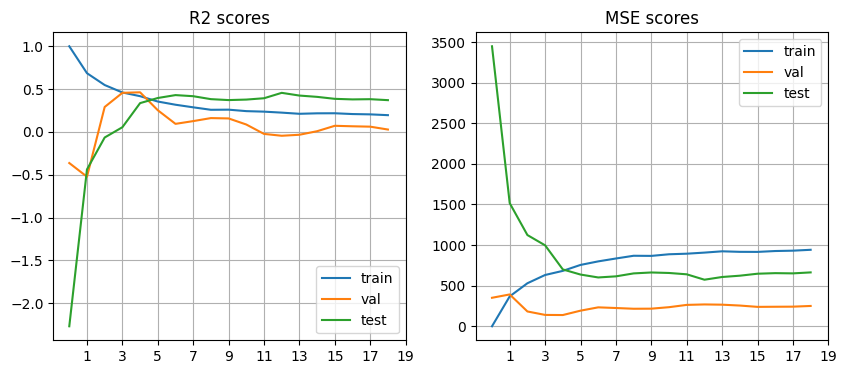

In [12]:
f, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot( r2s)
ax[0].legend(['train', 'val', 'test'])
ax[0].set_xticks(range(n_min, n_max, 2))
ax[0].grid()
ax[0].set_title("R2 scores")
ax[1].plot(mses)
ax[1].legend(['train', 'val', 'test'])
ax[1].set_xticks(range(n_min, n_max, 2))
ax[1].set_title("MSE scores")
ax[1].grid()

In [15]:
n_neighbours = 5
model = KNeighborsRegressor(n_neighbors=n_neighbours)
reg = model.fit(X_train_scaled, y_train_scaled)

# Evaluate on training set
y_pred = reg.predict(X_train_scaled)
mse = mean_squared_error(y_train_scaled, y_pred)
mae = mean_absolute_error(y_train_scaled, y_pred)
r2 = r2_score(y_train_scaled, y_pred)
print("Training set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))

  # Evaluate on test set
y_pred = reg.predict(X_val_scaled)
y_pred = np.nan_to_num(y_pred)
mse = mean_squared_error(y_val_scaled, y_pred)
mae = mean_absolute_error(y_val_scaled, y_pred)
r2 = r2_score(y_val_scaled, y_pred)
print("Validation set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))

  # Evaluate on test set
y_pred = reg.predict(X_test_scaled)
y_pred = np.nan_to_num(y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)
print("Test set scores for %d neighbours: mse %f, mae %f, r2 %f" % (n_neighbours, mse, mae, r2))

Training set scores for 5 neighbours: mse 682.338354, mae 11.177990, r2 0.417433
Validation set scores for 5 neighbours: mse 138.359085, mae 8.650331, r2 0.462570
Test set scores for 5 neighbours: mse 700.078868, mae 14.724028, r2 0.336335


In [1]:
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os

In [17]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="movies_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + f"/k-neighbours{n_neighbours}.pkl")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train_scaled)
output_schema = Schema(y_train_scaled)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
movie_model = mr.python.create_model(
    name=f"movie_kn{n_neighbours}",
    metrics={"r2" : r2},
    model_schema=model_schema,
    description="Movie revenue predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
movie_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/27868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/27868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/632 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/602262/models/movie_kn5/1


Model(name: 'movie_kn5', version: 1)

In [1]:
import pandas as pd
import numpy as np
import hopsworks
import joblib

project = hopsworks.login()
fs = project.get_feature_store()
movie_fg = fs.get_feature_group(name="movies", version=2)


Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/602262
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
query = movie_fg.select(['id']).read()
print(query)

Finished: Reading data from Hopsworks, using ArrowFlight (1.19s) 
         id
0    191714
1     46386
2    461707
3     19703
4     45316
..      ...
317   44613
318  883280
319  402672
320  360814
321  596650

[322 rows x 1 columns]


In [3]:
import requests
tmdb_api_key = os.getenv("TMDB_API_KEY")
url = f"https://api.themoviedb.org/3/movie/upcoming?api_key={tmdb_api_key}&original_language=hi"
response = requests.get(url).json()

In [5]:
url = f"https://api.themoviedb.org/3/discover/movie?api_key={tmdb_api_key}&include_adult=false&include_video=false&sort_by=revenue.desc&with_original_language=hi"
url

'https://api.themoviedb.org/3/discover/movie?api_key=85378515d04f91ab8e73cb54a7a934f6&include_adult=false&include_video=false&sort_by=revenue.desc&with_original_language=hi'

In [7]:
url = f"https://api.themoviedb.org/3/discover/movie?api_key={tmdb_api_key}&include_adult=false&include_video=false&with_original_language=hi&page=1&sort_by=popularity.desc&with_release_type=2|3&release_date.gte=2024-03-01"
url

'https://api.themoviedb.org/3/discover/movie?api_key=85378515d04f91ab8e73cb54a7a934f6&include_adult=false&include_video=false&with_original_language=hi&page=1&sort_by=popularity.desc&with_release_type=2|3&release_date.gte=2024-03-01'

In [29]:
url

'https://api.themoviedb.org/3/discover/movie?include_adult=false&include_video=false&language=en-US&page=1&sort_by=popularity.desc&with_release_type=2|3&release_date.gte=2024-03-01'

In [16]:
response

{'adult': False,
 'backdrop_path': '/hZkgoQYus5vegHoetLkCJzb17zJ.jpg',
 'belongs_to_collection': None,
 'budget': 63000000,
 'genres': [{'id': 18, 'name': 'Drama'}],
 'homepage': 'http://www.foxmovies.com/movies/fight-club',
 'id': 550,
 'imdb_id': 'tt0137523',
 'original_language': 'en',
 'original_title': 'Fight Club',
 'overview': 'A ticking-time-bomb insomniac and a slippery soap salesman channel primal male aggression into a shocking new form of therapy. Their concept catches on, with underground "fight clubs" forming in every town, until an eccentric gets in the way and ignites an out-of-control spiral toward oblivion.',
 'popularity': 103.27,
 'poster_path': '/pB8BM7pdSp6B6Ih7QZ4DrQ3PmJK.jpg',
 'production_companies': [{'id': 711,
   'logo_path': '/tEiIH5QesdheJmDAqQwvtN60727.png',
   'name': 'Fox 2000 Pictures',
   'origin_country': 'US'},
  {'id': 508,
   'logo_path': '/7cxRWzi4LsVm4Utfpr1hfARNurT.png',
   'name': 'Regency Enterprises',
   'origin_country': 'US'},
  {'id': 470